figures for the 10 minute talk at EARS

In [1]:
from pathlib import Path
import itertools as itt

import joblib as jl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
from bioinfokit.analys import stat
import pandas as pd
import seaborn as sns
from IPython.display import display
from statannot import add_stat_annotation
from cycler import cycler

from src.data.region_map import region_map
from src.visualization.fancy_plots import savefig
from src.metrics.consolidated_dprimes import _load_site_formated_raste, single_cell_dprimes, full_dPCA_dprimes
from src.data.dPCA import _cpp_dPCA, format_raster
from src.visualization.fancy_plots import _raster, unit_line
from src.metrics.significance import _significance
from src.metrics.dprime import flip_dprimes
from src.metrics.reliability import signal_reliability
from src.data.rasters import raster_from_sig
from src.data.load import load

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2021-04-13 130915.log
/auto/users/mateo/nems_db/nems_lbhb/SettingXML.py:66: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  {K: SubEl.get(K) for K in SubEl.keys() if K is not 'name'}
/auto/users/mateo/nems_db/nems_lbhb/SettingXML.py:76: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  {K: SubEl.get(K) for K in SubEl.keys() if K is not 'name'}
/auto/users/mateo/nems_db/nems_lbhb/SettingXML.py:81: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  {K: SubEl.get(K) for K in SubEl.keys() if K is not 'name'}
[numexpr.utils INFO] NumExpr defaulting to 8 threads.


In [2]:
#general plottin formating
plt.style.use('dark_background')

light_color_cycle = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

trans_color_map = {'silence': '#377eb8',  # blue
                   'continuous': '#ff7f00',  # orange
                   'similar': '#4daf4a',  # green
                   'sharp': '#a65628'}  # brown

params = {'axes.labelsize': 15,
          'axes.titlesize': 20,
          'axes.spines.top': False,
          'axes.spines.right': False,
          'axes.prop_cycle': light_color_cycle,
          'xtick.labelsize': 11,
          'ytick.labelsize': 11,
          'lines.markersize': 8,
          'figure.titlesize': 30,
          'figure.figsize': [4,4],
          'figure.autolayout':True,
          'svg.fonttype': 'none',
          'font.sans-serif': 'Arial',
          'legend.loc': 'upper right',
          'legend.frameon': False,
          'legend.fontsize': 15,
          'legend.markerscale': 3,
          }

widescreen = [13.3, 7.5]

plt.rcParams.update(params)

In [3]:
# pulls DF, removes unused columns and data, refactor redunant id columns and create probe_id
DF = jl.load(Path(f'../data/210302_consolidated_summary_DF_alpha_0.05/dprime_absolute-None_montecarlo-1000_raster_fs-30_reliability-0.1_smoothing_window-0_zscore-True'))

In [261]:
# permutation related preprocesing.

# no need for means or mean policy, working on permutations only
ff_probe = DF.probe != 'mean'
ff_pairs = DF.context_pair != 'mean'
ff_mean = DF.mean_signif_type == 'shuffles'

ff_stim = DF.stim_type == 'permutations'

ff_analylis = DF.analysis.isin(['SC', 'fdPCA', 'pdPCA', 'LDA'])
ff_corr = DF.mult_comp_corr == 'consecutive_3'
ff_metric = DF.metric.isin(['significant_abs_mass_center', 'significant_abs_sum'])

good_cols =['analysis', 'mult_comp_corr', 'region', 'siteid',  'cellid', 'context_pair',
            'probe', 'metric', 'value']
filtered = DF.loc[ff_stim & ff_mean & ff_pairs & ff_probe & ff_analylis & ff_corr & ff_metric, good_cols]

# rename metrics and analysis for ease of ploting
filtered['metric'] = filtered['metric'].replace({'significant_abs_mass_center': 'center of mass (ms)',
                                                 'significant_abs_mean': "mean d'",
                                                 'significant_abs_sum': "integral (d'*ms)"})
filtered['analysis'] = filtered['analysis'].replace({'SC': 'single cell',
                                                     'fdPCA': 'population',
                                                     'pdPCA': 'probewise pop',
                                                     'LDA': 'pop ceiling'})

filtered['id'] = filtered['cellid'].fillna(value=filtered['siteid'])
filtered = filtered.drop(columns=['cellid', 'siteid'])

filtered['value'] = filtered['value'].fillna(value=0)

# creates a new column relating probe with  context pairs
ctx = np.asarray([row.split('_') for row in filtered.context_pair], dtype=int)
prb = np.asarray(filtered.probe, dtype=int)

silence = ctx == 0
same = ctx == prb[:,None]
different = np.logical_and(~silence, ~same)

name_arr = np.full_like(ctx, np.nan, dtype=object)
name_arr[silence] = 'silence'
name_arr[same] = 'same'
name_arr[different] = 'diff'
comp_name_arr = np.apply_along_axis('_'.join, 1, name_arr)

# swaps clasification names to not have repetitions i.e. diff_same == same_diff
comp_name_arr[np.where(comp_name_arr == 'same_silence')] = 'silence_same'
comp_name_arr[np.where(comp_name_arr == 'diff_silence')] = 'silence_diff'
comp_name_arr[np.where(comp_name_arr == 'diff_same')] = 'same_diff'
comp_name_arr[np.where(comp_name_arr == 'same_silence')] = 'silence_same'

filtered['trans_pair'] = comp_name_arr

ord_cols = ['analysis', 'region', 'id', 'context_pair', 'trans_pair', 'probe', 'metric', 'value']
pivot_idx = [col for col in ord_cols if col not in ['value', 'metric']]
pivoted = filtered.pivot_table(index=pivot_idx, columns='metric', values='value', aggfunc='first').reset_index()

full_long = filtered # saves long format for subsamplig analysis

In [262]:
# counts the total number of values for each comparison (SC, fDPCA) x (sile_diff, sile_same, diff_diff, same_diff)
# counts the proportion of signifciant vs non singificant(zero-zero) values
# decimates the more numerous comparisons??

# set the array to group by id, context_pair, and probe. Keeping analysis, region and transision_pair
# the final array should have analysis, region and trans pair as rowns, and total count, and significants as columns

def nozero_mean(arr):
    arr[arr==0] = np.nan
    return np.nanmean(arr)

def nozero_count(arr):
    return np.sum(arr>0)


group_ready = pivoted.set_index(['analysis', 'region', 'trans_pair']).loc[:, filtered.metric.unique()]
agg_funcs = {'center of mass (ms)': [('mean duration', nozero_mean)],
             "integral (d'*ms)": [('mean amplitude', nozero_mean),
                                     ('total', 'size'),
                                     ('n_signif', nozero_count)]}

grouped = group_ready.groupby(['analysis', 'region', 'trans_pair']).agg(agg_funcs)
grouped.columns = grouped.columns.droplevel(0)
grouped['significant %'] = grouped.n_signif / grouped.total * 100

## count number of cells or sites with significant contextual effects

In [264]:
for anal in ['single cell', 'population', 'probewise pop', 'pop ceiling']:
    all_id_df= pivoted.loc[pivoted.analysis == anal, ['id']]
    all_id_count = len(all_id_df.id.unique())

    good_id_df= pivoted.loc[(pivoted.analysis == anal) & (pivoted["integral (d'*ms)"] > 0), ['id']]
    good_id_count = len(good_id_df.id.unique())

    print(f'{anal}\n{good_id_count} of {all_id_count}. {good_id_count/all_id_count*100:.2f}%')

single cell
581 of 862. 67.40%
population
35 of 35. 100.00%
probewise pop
35 of 35. 100.00%
pop ceiling
34 of 35. 97.14%


## how many contextual instances per site/cell and on average

In [265]:
goodcount = pivoted.set_index(['analysis', 'id']).loc[:,["integral (d'*ms)"]]
agg_funcs = {"integral (d'*ms)": [('all',np.size),
                                  ('good', nozero_count)]}
goodcount = goodcount.groupby(['analysis','id']).agg(agg_funcs)
goodcount.columns = goodcount.columns.droplevel(0)
goodcount = goodcount.loc[goodcount['good'] > 0]
goodcount['percent'] = goodcount['good'] / goodcount['all'] * 100
# display(goodcount)

for anal in ['single cell', 'population', 'probewise pop', 'pop ceiling']:
    arr = goodcount.loc[(anal), 'percent'].values
    print(f'{anal}\n{np.mean(arr):.2f}% significant instances on average')

single cell
14.36% significant instances on average
population
47.00% significant instances on average
probewise pop
46.07% significant instances on average
pop ceiling
39.71% significant instances on average


## count of significant instances
### single cell

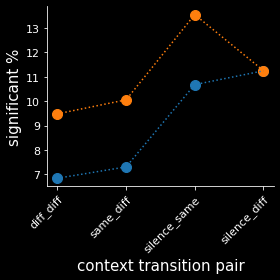

In [235]:
analysis = 'single cell'
value = 'significant %'

fig, ax = plt.subplots()

toplot = grouped.loc[(analysis), (value)]
toplot = toplot.reset_index()
toplot = toplot.pivot(values=value, columns='region', index='trans_pair')
toplot = toplot.reindex(index=['diff_diff', 'same_diff', 'silence_same', 'silence_diff'])

_ = ax.plot(toplot.A1, color='C0', linestyle=':', label='A1')
_ = ax.scatter(range(4), toplot.A1, color='C0', s=100)
_ = ax.plot(toplot.PEG, color='C1', linestyle=':', label='PEG')
_ = ax.scatter(range(4), toplot.PEG, color='C1', s=100)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_ylabel('significant %')
ax.set_xlabel('context transition pair')
fig.set_size_inches(4,4)
title = 'single_cell_signif_percent_plot'
savefig(fig, 'DAC4_figures', title)

### population

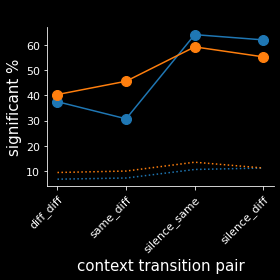

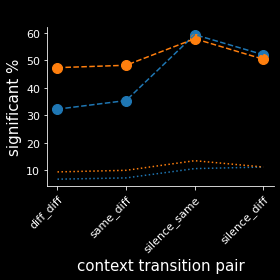

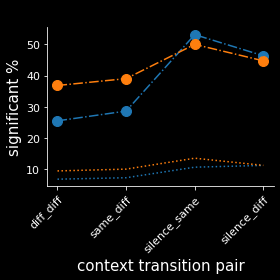

In [266]:
# for the population plots both single cell and population

analyses = ['population', 'probewise pop', 'pop ceiling']
linestyles = ['-', '--', '-.']

for analysis, linestyle in zip(analyses, linestyles):
    fig, ax = plt.subplots()

    value = 'significant %'

    toplot = grouped.loc[('single cell'), (value)]
    toplot = toplot.reset_index()
    toplot = toplot.pivot(values=value, columns='region', index='trans_pair')
    toplot = toplot.reindex(index=['diff_diff', 'same_diff', 'silence_same', 'silence_diff'])

    _ = ax.plot(toplot.A1, color='C0', linestyle=':', label=f'single cell A1')
    _ = ax.plot(toplot.PEG, color='C1', linestyle=':', label=f'single cell PEG')

    # population
    toplot = grouped.loc[(analysis), (value)]
    toplot = toplot.reset_index()
    toplot = toplot.pivot(values=value, columns='region', index='trans_pair')
    toplot = toplot.reindex(index=['diff_diff', 'same_diff', 'silence_same', 'silence_diff'])

    _ = ax.plot(toplot.A1, color='C0', linestyle=linestyle, label=f'{analysis} A1')
    _ = ax.scatter(range(4), toplot.A1, color='C0', s=100)
    _ = ax.plot(toplot.PEG, color='C1', linestyle=linestyle, label=f'{analysis} PEG')
    _ = ax.scatter(range(4), toplot.PEG, color='C1', s=100)

    # format ax labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    ax.set_ylabel('significant %')
    ax.set_xlabel('context transition pair')

    ax.set_title(' ')
    fig.set_size_inches(4,4)

    title = f'{analysis}_signif_percent_plot'
    savefig(fig, 'DAC4', title)

In [267]:
trans_ord = ['diff_diff', 'same_diff', 'silence_same', 'silence_diff']
reg_ord = ['A1', 'PEG']
ana_ord = ['single cell', 'population']

In [244]:
# grid with proportion anotations
def anotated_nozero_scatter(x, y, **kws):
    total = x.shape[0]
    x = x[x>0]
    y = y[y>0]
    fontsize = kws.pop('fontsize', 12)
    n_signif = len(x)
    percent_good = n_signif / total * 100

    ax = plt.gca()
    ax.scatter(x, y, s=8, alpha=1, **kws)
    sns.kdeplot(x=x, y=y, ax=ax,**kws)
    ax.set_xlim(0,ax.get_xlim()[1])
    ax.set_ylim(0,ax.get_ylim()[1])

    ax.text(.5, 0.5, f'n {total}\n{percent_good:.2f}% signif', fontsize=fontsize, transform=ax.transAxes, **kws)


# plots showing the progression of the date split
## single cell

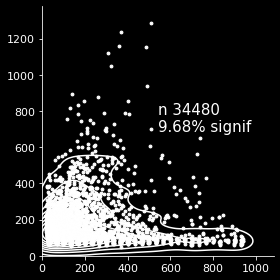

In [245]:
scDF = pivoted.loc[pivoted.analysis == 'single cell',:]

g = sns.FacetGrid(data=scDF, row=None, col=None, hue=None,
                  sharex=True, sharey=True, legend_out=True,
                  row_order=ana_ord, col_order=trans_ord, hue_order=reg_ord)
g.map(anotated_nozero_scatter, 'center of mass (ms)', "integral (d'*ms)", color='white', fontsize=15)
g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")
# g.set_axis_labels("duration of contextual\ndiscrimination (ms)",
#                   "magnitude of contextual\ndiscrimination (d' * ms)")
g.set_axis_labels("",
                  "")
fig = g.fig
fig.set_size_inches(4, 4)

title = 'single_cell_parameter_space_pooled'
savefig(fig, 'DAC4', title)

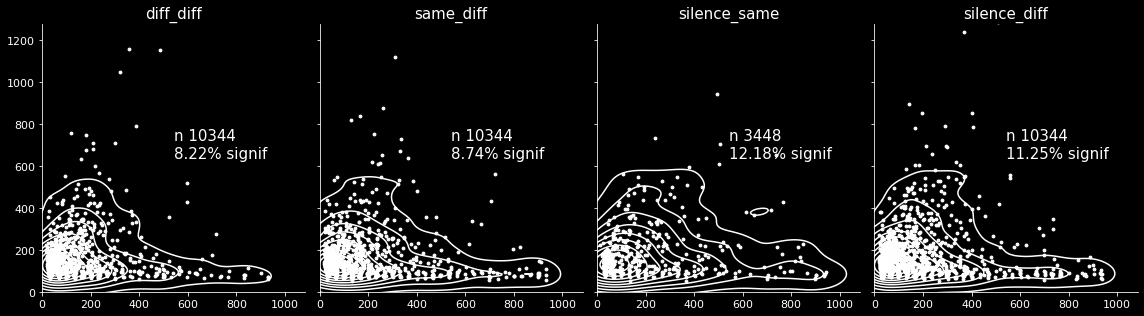

In [247]:
scDF = pivoted.loc[pivoted.analysis == 'single cell',:]
g = sns.FacetGrid(data=scDF, row=None, col='trans_pair', hue=None,
                  sharex=True, sharey=True, legend_out=True,
                  row_order=ana_ord, col_order=trans_ord, hue_order=reg_ord)
g.map(anotated_nozero_scatter, 'center of mass (ms)', "integral (d'*ms)", color='white', fontsize=15)
g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="", col_template="{col_name}")
g.set_axis_labels("",
                  "")
fig = g.fig
fig.set_size_inches(16,4.5)

title = 'single_cell_parameter_space_transitions'
savefig(fig, 'DAC4', title)

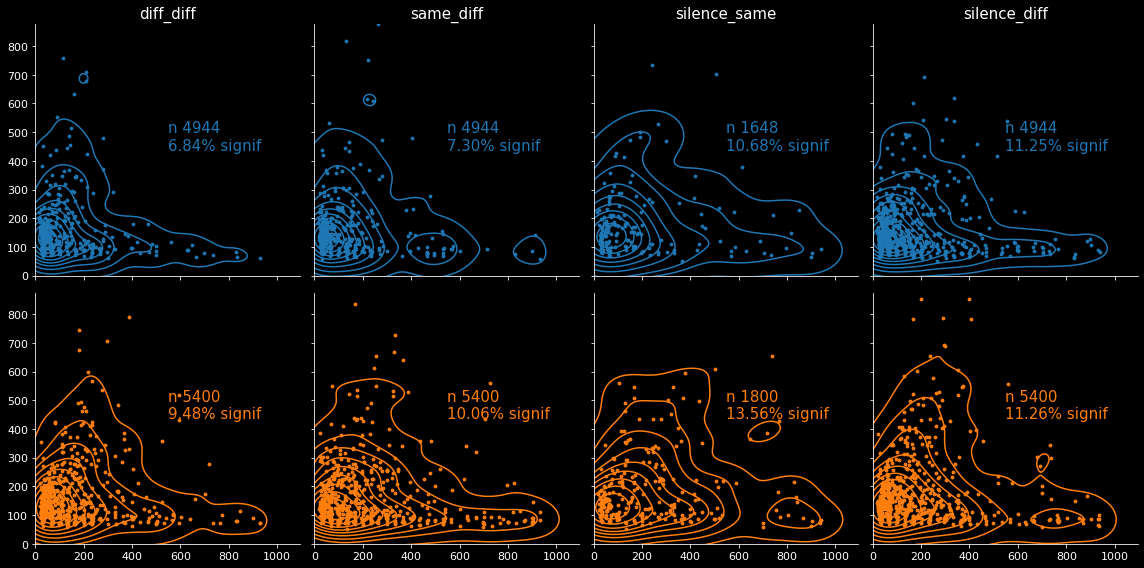

In [248]:
scDF = pivoted.loc[pivoted.analysis == 'single cell',:]
g = sns.FacetGrid(data=scDF, row='region', col='trans_pair', hue='region',
                  sharex=True, sharey=True, legend_out=True,
                  row_order=reg_ord, col_order=trans_ord, hue_order=reg_ord)
g.map(anotated_nozero_scatter, 'center of mass (ms)', "integral (d'*ms)", fontsize=15)
g.set_titles(template="")
# g.set_axis_labels("duration of contextual\ndiscrimination (ms)",
#                   "magnitude of contextual\ndiscrimination (d' * ms)")
g.set_axis_labels("",
                  "")
g._margin_titles = True
g.set_titles(row_template="", col_template="{col_name}")
fig = g.fig
fig.set_size_inches(16,8)

title = 'single_cell_parameter_space_trans_region'
savefig(fig, 'DAC4', title)

## Population

population
probewise pop
pop ceiling


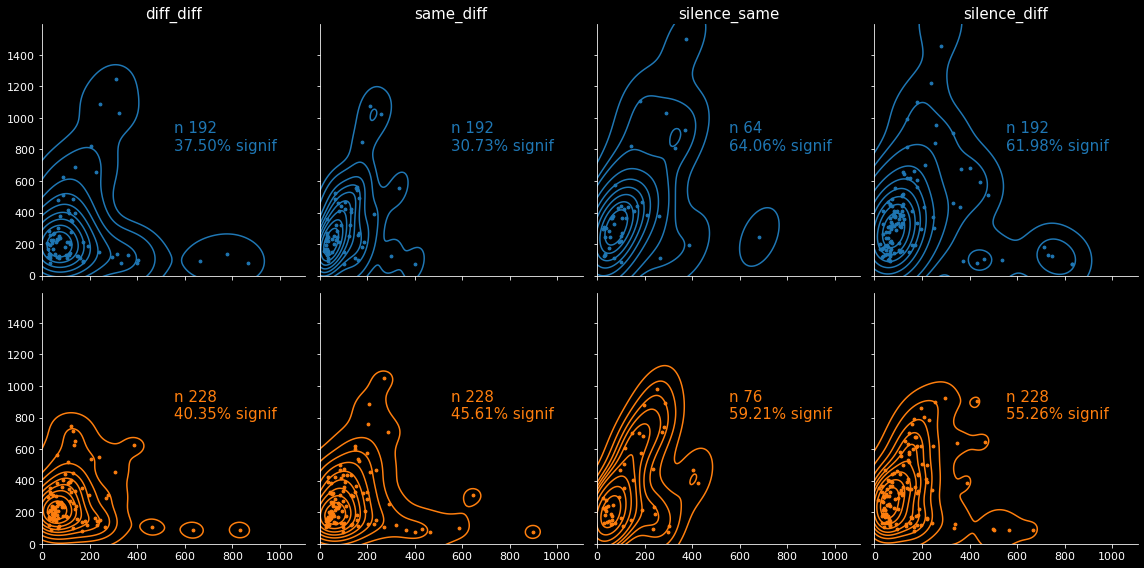

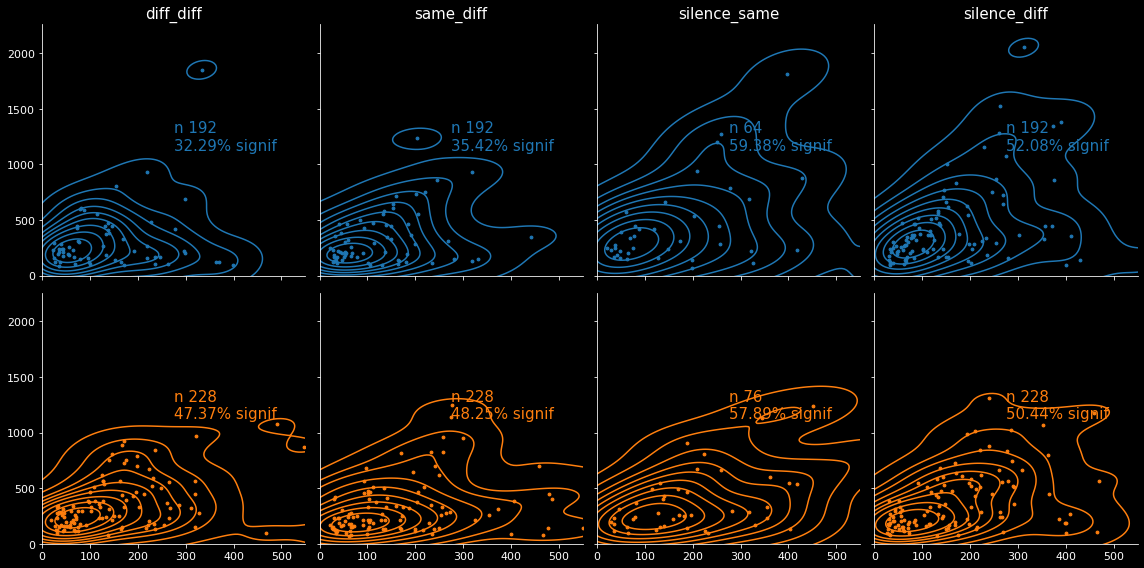

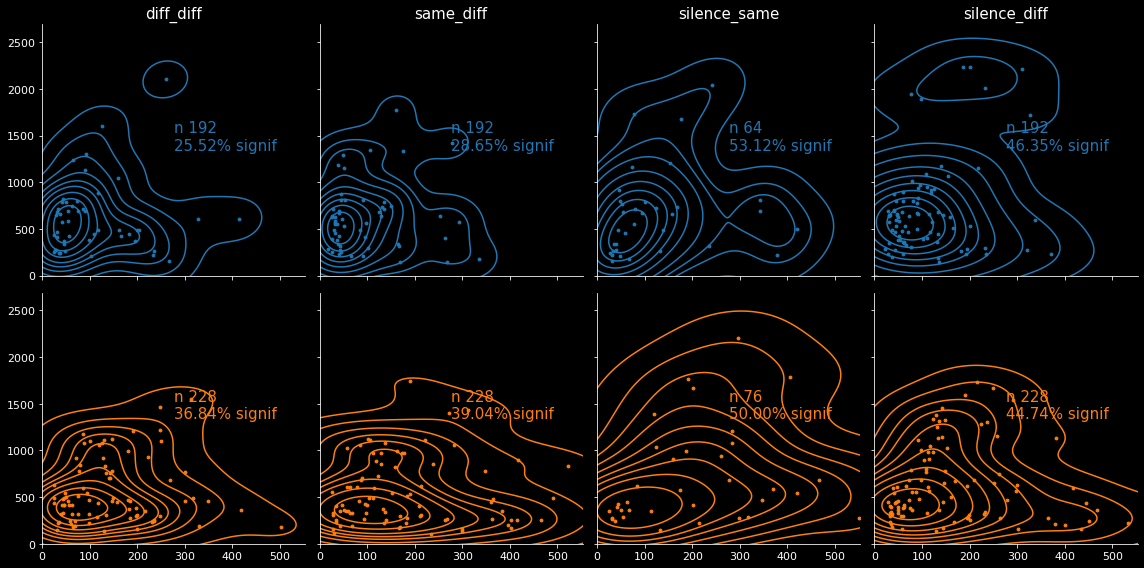

In [269]:
analyses = ['population', 'probewise pop', 'pop ceiling']
for analysis in analyses:
    print(analysis)
    scDF = pivoted.loc[pivoted.analysis == analysis,:]
    g = sns.FacetGrid(data=scDF, row='region', col='trans_pair', hue='region',
                      sharex=True, sharey=True, legend_out=True,
                      row_order=reg_ord, col_order=trans_ord, hue_order=reg_ord)
    g.map(anotated_nozero_scatter, 'center of mass (ms)',  "integral (d'*ms)", fontsize=15)
    g.set_titles(template="")
    g.set_axis_labels("",
                      "")
    g._margin_titles = True
    g.set_titles(row_template="", col_template="{col_name}")
    fig = g.fig
    fig.set_size_inches(16,8)

    title = f'{analysis}_parameter_space_trans_region'
    savefig(fig, 'DAC4', title)


# Anova tables

In [270]:
for ana, met in itt.product(['single cell', 'population', 'probewise pop', 'pop ceiling'], ['center of mass (ms)', "integral (d'*ms)"]):
    ff_metric = filtered.metric == met
    ff_analysis = filtered.analysis == ana
    ff_val = filtered.value > 0
    anovaDF =  filtered.loc[ff_metric & ff_analysis & ff_val,
                         ['region', 'trans_pair', 'value']]

    modstr = 'value ~ C(region) + C(trans_pair) + C(region):C(trans_pair)'
    model = ols(modstr, data=anovaDF).fit()
    df = sm.stats.anova_lm(model, typ=2)

    title =f'\n {ana} {met}'
    print(title)
    print(df)

    # post hoc comparisons
    res = stat()
    for comp in ['region', 'trans_pair']:
        res.tukey_hsd(df=anovaDF, res_var= 'value', xfac_var=comp, anova_model=modstr)
        phocdf = res.tukey_summary
        phocdf = phocdf.loc[:, ['group1', 'group2', 'p-value']]
        print('\n', phocdf)



 single cell center of mass (ms)
                               sum_sq      df          F        PR(>F)
C(region)                1.579921e+06     1.0  48.207189  4.590747e-12
C(trans_pair)            1.056350e+06     3.0  10.743926  5.030272e-07
C(region):C(trans_pair)  3.149195e+05     3.0   3.202984  2.232604e-02
Residual                 1.091359e+08  3330.0        NaN           NaN

   group1 group2  p-value
0    PEG     A1    0.001

          group1        group2   p-value
0  silence_same  silence_diff  0.027783
1  silence_same     same_diff  0.034926
2  silence_same     diff_diff  0.001000
3  silence_diff     same_diff  0.900000
4  silence_diff     diff_diff  0.002703
5     same_diff     diff_diff  0.005862

 single cell integral (d'*ms)
                               sum_sq      df         F    PR(>F)
C(region)                1.197519e+05     1.0  8.377019  0.003825
C(trans_pair)            1.147354e+05     3.0  2.675366  0.045648
C(region):C(trans_pair)  2.907397e+04     3.0  0

# post hoc comparisons

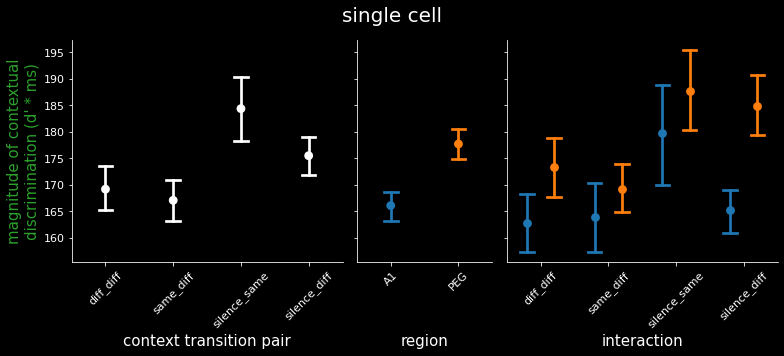

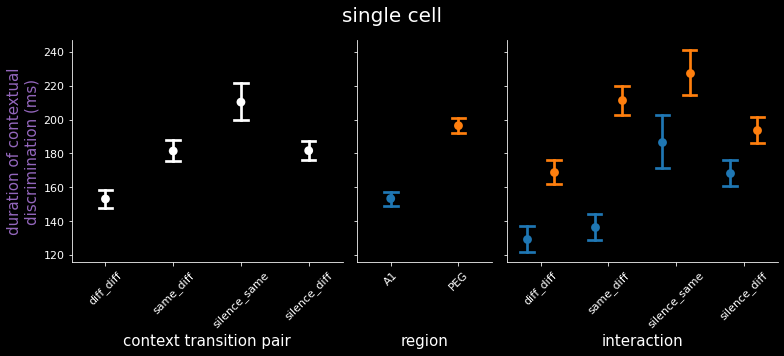

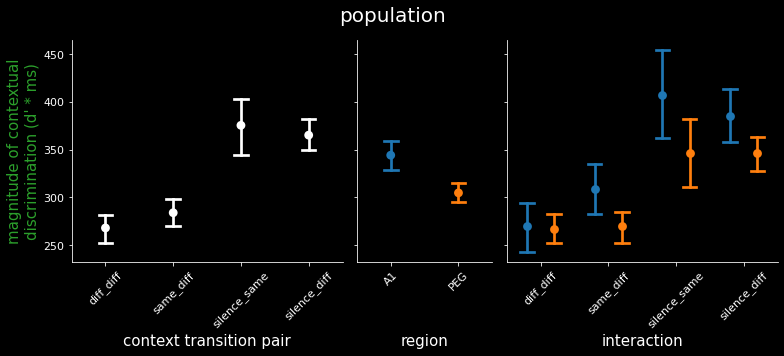

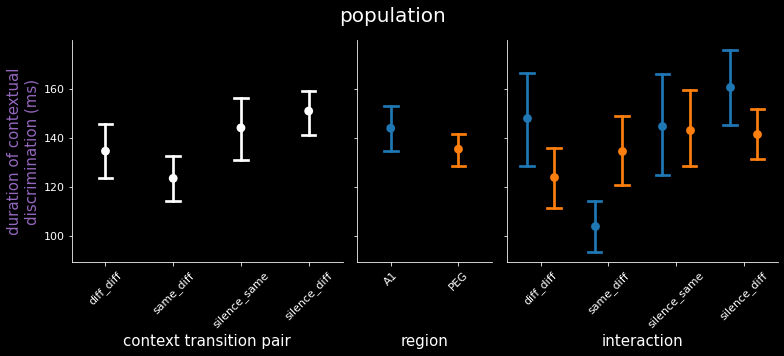

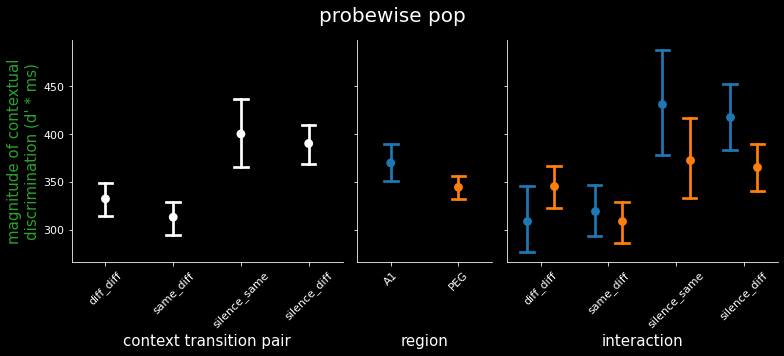

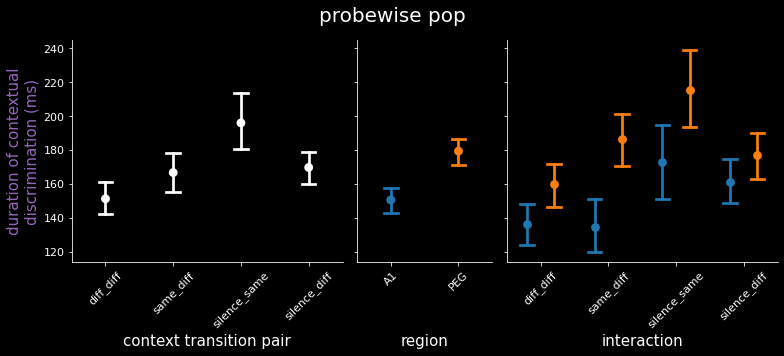

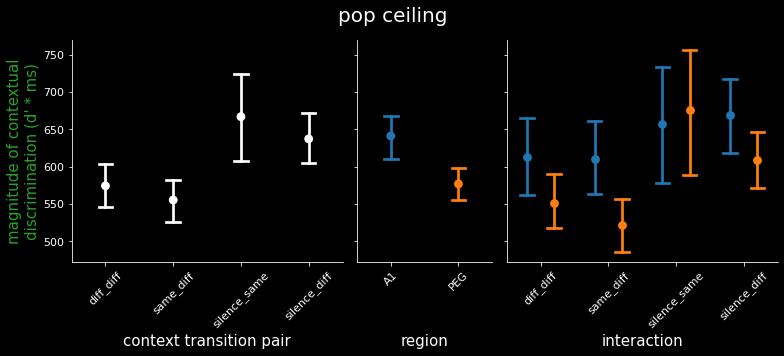

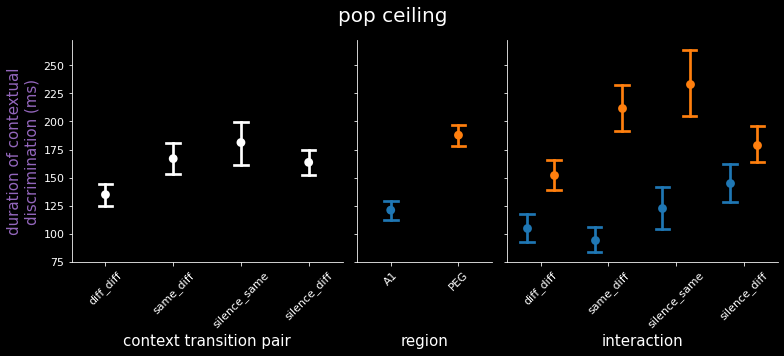

In [272]:
metrics = ["integral (d'*ms)", "center of mass (ms)"]
analyses = ['single cell', 'population', 'probewise pop', 'pop ceiling']
for analysis, metric in itt.product(analyses, metrics):
    tocalc = filtered.loc[(filtered.metric == metric) &
                          (filtered.analysis == analysis) &
                          (filtered.value >0),:]

    toplot = tocalc.loc[(tocalc.value < 600), :]

    if metric == "integral (d'*ms)":
        mname = 'integral'
        ylname = "magnitude of contextual\ndiscrimination (d' * ms)"
        lab_color = 'C2'
    elif metric == "center of mass (ms)":
        mname = 'center_of_mass'
        ylname = "duration of contextual\ndiscrimination (ms)"
        lab_color = 'C4'

    # plots the comparison by transition pair and by region in subplots of the same figures
    # gs_kw = dict(width_ratios=[1,0.5], height_ratios=[1])
    gs_kw = dict(width_ratios=[1, 0.5, 1], height_ratios=[1])
    # fig, (trans_ax, reg_ax) = plt.subplots(1, 2, sharey=True, gridspec_kw=gs_kw)
    fig, (trans_ax, reg_ax, int_ax) = plt.subplots(1, 3, sharey=True, gridspec_kw=gs_kw)
    fig.set_size_inches(11,5)

    #transitions
    _ = sns.pointplot(x='trans_pair', y='value', data=tocalc, order=trans_ord, hue_order=reg_ord,
                       s=2, dodge=0.4, join=False, palette=['white'], capsize=0.2, ci=68, ax=trans_ax)
    trans_ax.legend([],[], frameon=False)
    trans_ax.set_xticklabels(trans_ord, rotation = 45)

    trans_ax.set_xlabel('context transition pair')
    trans_ax.set_ylabel(ylname)
    trans_ax.yaxis.label.set_color(lab_color)

    # regions
    _ = sns.pointplot(x='region', y='value', data=tocalc, order=reg_ord, hue_order=reg_ord,
                       s=2, dodge=0.4, join=False, palette=sns.color_palette(), capsize=0.2, ci=68, ax=reg_ax)

    reg_ax.legend([],[], frameon=False)
    reg_ax.set_xticklabels(reg_ord, rotation = 45)
    reg_ax.set_xlabel('region')
    reg_ax.set_ylabel("")

    # interaction
    int_ax = sns.pointplot(x='trans_pair', y='value', hue='region', data=tocalc, order=trans_ord, hue_order=reg_ord,
                   s=2, dodge=0.4, join=False, capsize=0.2, ci=68, ax=int_ax)
    int_ax.legend([],[], frameon=False)
    int_ax.set_xticklabels(trans_ord, rotation = 45)
    int_ax.set_xlabel('interaction')
    int_ax.set_ylabel('')

    fig.align_labels()
    title =f'{analysis}_post_hoc_{mname}'
    fig.suptitle(f'{analysis}', fontsize=20)
    savefig(fig,'DAC4', title)

# single cell population comparison

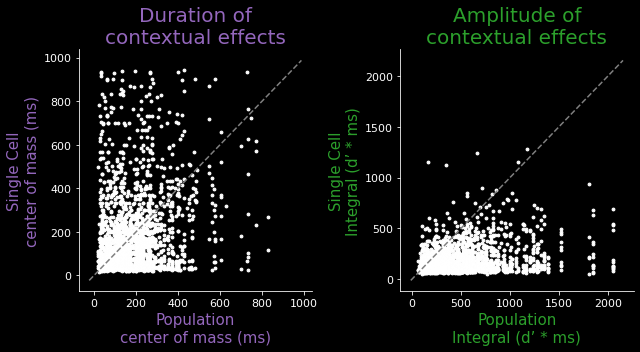

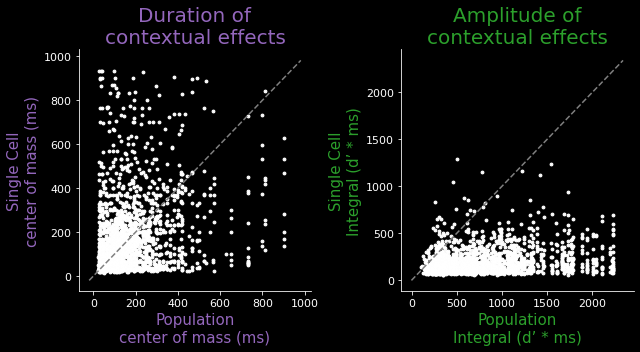

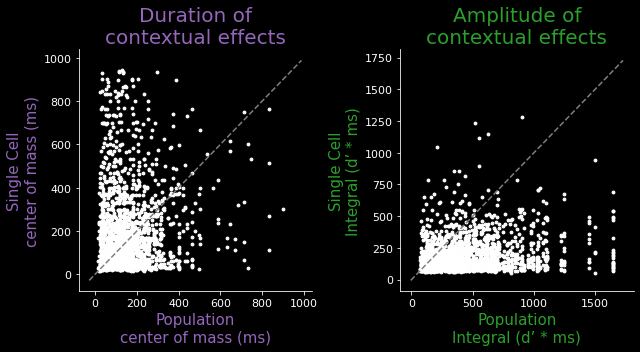

In [287]:
indexed = pivoted
indexed['siteid'] = pivoted['id'].apply(lambda x: x[:7] )
# indexed = indexed.set_index(['analysis', 'id', 'region', 'siteid', 'context_pair', 'trans_pair', 'probe'])
indexed = indexed.set_index(['analysis', 'siteid', 'probe', 'region', 'context_pair', 'trans_pair'])


analyses = ['probewise pop', 'pop ceiling', 'population']
for analysis in analyses:
    merge = pd.merge(left=indexed.loc['single cell'], right=indexed.loc[analysis],
                     left_index=True, right_index=True,
                     suffixes=(' single cell', ' population'))
    # display(merge)

    filtmerge = merge.loc[(merge["integral (d'*ms) single cell"]>0) &
                          (merge["integral (d'*ms) population"]>0), :
                          ].drop(columns=(f'id population')).rename(columns={'id single cell': 'cellid'})

    fig, (dur_ax, amp_ax) = plt.subplots(1,2)
    fig.set_size_inches(9,5)

    dur_ax.scatter(filtmerge.loc[:,"center of mass (ms) population"], filtmerge.loc[:,"center of mass (ms) single cell"],
                   color='white', s=8)
    dur_ax.set_xlabel("Population\ncenter of mass (ms)")
    dur_ax.set_ylabel("Single Cell\ncenter of mass (ms)")
    dur_ax.xaxis.label.set_color('C4')
    dur_ax.yaxis.label.set_color('C4')
    dur_ax.set_title('Duration of\ncontextual effects', color='C4')

    amp_ax.scatter(filtmerge.loc[:,"integral (d'*ms) population"], filtmerge.loc[:,"integral (d'*ms) single cell"],
                   color='white', s=8)
    amp_ax.set_xlabel("Population\nIntegral (d’ * ms)")
    amp_ax.set_ylabel("Single Cell\nIntegral (d’ * ms)")
    amp_ax.xaxis.label.set_color('C2')
    amp_ax.yaxis.label.set_color('C2')
    amp_ax.set_title('Amplitude of\ncontextual effects', color='C2')

    for ax in (dur_ax, amp_ax):
        _ = unit_line(ax, True)

    title =f'SC_{analysis}_metric_comparison'
    savefig(fig, "DAC4", title)


# Example cell

In [276]:
best_cells = pivoted.loc[(pivoted.analysis == 'single cell') &
                         (pivoted['center of mass (ms)'] > 0),
                         ['region', 'id', 'context_pair', 'trans_pair',
                          'probe', "center of mass (ms)", "integral (d'*ms)"]]
best_cells = best_cells.sort_values(by=["integral (d'*ms)", 'center of mass (ms)'], ascending=[False, False])
display(best_cells.head(5))

metric,region,id,context_pair,trans_pair,probe,center of mass (ms),integral (d'*ms)
37774,PEG,CRD012b-13-1,0_4,silence_diff,3,507.079994,1284.997683
29761,PEG,ARM021b-36-8,0_1,silence_diff,3,369.224941,1238.284103
29776,PEG,ARM021b-36-8,1_2,diff_diff,3,358.137677,1156.687105
37785,PEG,CRD012b-13-1,1_4,diff_diff,3,484.889532,1151.055683
5778,A1,AMT021b-05-2,1_2,same_diff,1,308.933576,1120.160911


# psth and dprime plots for example cells/sites

In [277]:
alpha=0.05
meta = {'reliability': 0.1,  # r value
        'smoothing_window': 0,  # ms
        'raster_fs': 30,
        'montecarlo': 1000,
        'zscore': True,
        'dprime_absolute': None,
        'stim_type': 'permutations'}

expt = {'contexts': [0, 1, 2, 3, 4],
                'probes': [1, 2, 3, 4]}

def load_all_raw_data(id):

    # def analysis_steps_plot(id, probe):
    site = id[:7]
    if len(id) == 7:
        population = True
    else:
        population = False

    # loads the raw data
    raster, goodcells = _load_site_formated_raste(site, **expt, meta=meta)
    trialR, R, _ = format_raster(raster)

    if population:
        _, trialZ, dpca = _cpp_dPCA(R, trialR)
        dPCA_projection = trialZ['ct'][:, 0, ...][:,None,...]
        trialR = dPCA_projection
        dprime, shuffled_dprime, goodcells, dPCA = full_dPCA_dprimes(site, **expt, meta=meta)

    else:
        dprime, shuffled_dprime, goodcells, dPCA = single_cell_dprimes(site, **expt, meta=meta)


    dprime, shuffled_dprime = flip_dprimes(dprime, shuffled_dprime, flip='sum')
    significance, confidence_interval = _significance(dprime, shuffled_dprime, [3], 3, alpha=alpha)

    t =  np.linspace(0, dprime.shape[-1] / meta['raster_fs'], dprime.shape[-1],
                                            endpoint=False) * 1000

    return trialR, dprime, shuffled_dprime, significance, confidence_interval, goodcells, t


In [291]:
# PSTH and raster on the diagonal
def single_psth(trialR, cell_idx, trans_idx, probe_idx, ax):
    ax.plot(t, trialR[:, cell_idx, trans_idx, probe_idx, :].mean(axis=0), color=f'C{trans_idx}',
                     linewidth=3)
    return ax

def single_raster(trialR, cell_idx, trans_idx, probe_idx, ax):
    # plot raster only for single cells
    _ = _raster(t, trialR[:, cell_idx, trans_idx, probe_idx, :], y_offset=0, y_range=ax.get_ylim(), ax=ax,
                         scatter_kws={'color': f'C{trans_idx}', 'alpha': 0.4, 's': 10})
    return ax

# Paired PSTHs on the upper triangle
def double_psth(trialR, cell_idx, trans_idx_0, trans_idx_1, probe_idx, ax):
    ax.plot(t, trialR[:, cell_idx, trans_idx_0, probe_idx, :].mean(axis=0), color=f'C{trans_idx_0}',
                     linewidth=3)

    ax.plot(t, trialR[:, cell_idx, trans_idx_1, probe_idx, :].mean(axis=0), color=f'C{trans_idx_1}',
                     linewidth=3)
    return ax

# dprime plus CI on the lower triangle
def dprime_ci(dprime, confidence_interval, cell_idx, trans_idx_0, trans_idx_1, probe_idx, ax):
    trans_pair_idx = [f'{t0}_{t1}' for t0, t1 in itt.combinations(expt['contexts'], 2)
                      ].index(f'{trans_idx_0}_{trans_idx_1}')
    ax.plot(t, dprime[cell_idx, trans_pair_idx, probe_idx, :], color='white')
    ax.fill_between(t, confidence_interval[0, cell_idx, trans_pair_idx, probe_idx, :],
                    confidence_interval[1, cell_idx, trans_pair_idx, probe_idx, :],
                    color='white', alpha=0.5)
    return ax

# iterates over the grid
def grid_plot(id, trialR, dprime, confidence_interval, probe):

    cell_idx = goodcells.index(id) if len(id)>7 else 0
    probe_idx = expt['probes'].index(probe)

    fig = plt.figure(figsize=(8,8))
    gs = fig.add_gridspec(5,5)

    first_up = True
    first_lo = True

    diagonals = list()
    for x, y in itt.product(range(5),range(5)):

        # creates subplots with shared x axis for the diagonal and upper triangle
        if x <= y:
            if first_up:
                upax = fig.add_subplot(gs[x,y])
                ax = upax
                first_up = False
            else:
                ax = fig.add_subplot(gs[x,y], sharex=upax, sharey=upax)
        else:
            if first_lo:
                loax = fig.add_subplot(gs[x,y])
                ax = loax
                first_lo = False
            else:
                ax = fig.add_subplot(gs[x,y], sharex=upax, sharey=loax)

        # plots upper triangle psth
        if x < y:
            _ = double_psth(trialR, cell_idx, x, y, probe_idx, ax)


        #plots lower triangle dprime
        elif x > y:
            _ = dprime_ci(dprime, confidence_interval, cell_idx, y, x, probe_idx, ax)

        # plots diagonal raster
        else:
            _ = single_psth(trialR, cell_idx, x, probe_idx, ax)
            diagonals.append(ax)

        # removes time tick labels
        if x != 4:
            plt.setp(ax.get_xticklabels(), visible=False)

        # add time labels
        else:
            if y == 2:
                ax.set_xlabel('time (ms)')

        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        # removes y tick lables
        if y not in [0,4]:
            plt.setp(ax.get_yticklabels(), visible=False)

        # remove y labels on the first psth
        if y == 0 and x == 0:
            plt.setp(ax.get_yticklabels(), visible=False)

        # dprime labels on left side
        if y == 0 and x == 2:
            ax.set_ylabel("contextual effects discriminability (d')")

        # zscore firing rate ticks on right side
        if y == 4:
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position("right")
            if x == 2:
                ax.set_ylabel('firing rate (z-score)')
            ax.spines['right'].set_visible(True)

    if len(id)>7:
        for n, ax in enumerate(diagonals):
            _ =single_raster(trialR, cell_idx, n, probe_idx, ax)
    else:
        for n, ax in enumerate(diagonals):
            ax.axhline(0, color='white', linestyle='--')

    return fig

In [279]:
# example for methods.
id, probe= 'CRD004a-39-2', 4# <- great example
# id, probe = 'ARM031a-54-3', 1 # <- great example
id, probe= 'ARM021b-36-8', 3

trialR, dprime, shuffled_dprime, significance, confidence_interval, goodcells, t = load_all_raw_data(id)

loading recording from box


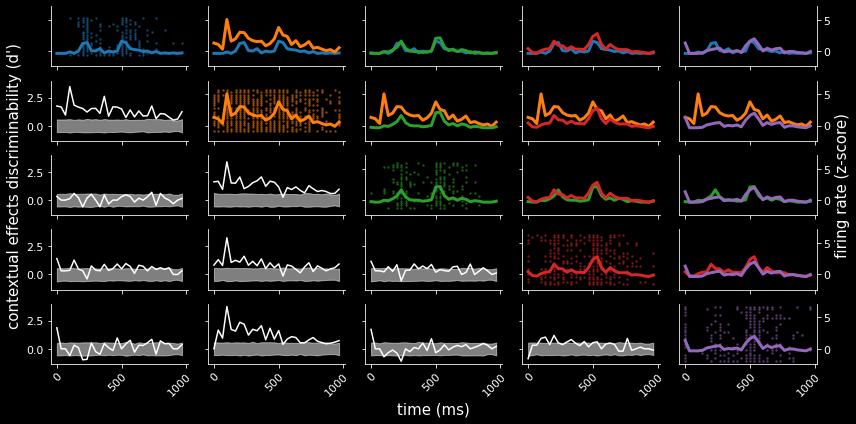

In [281]:
fig = grid_plot(id, trialR, dprime, confidence_interval, probe)
fig.set_size_inches(12,6)
title =f'context_pair_grid_{id}'
savefig(fig, "DAC4", title)

# PSTH with context included

loading recording from box


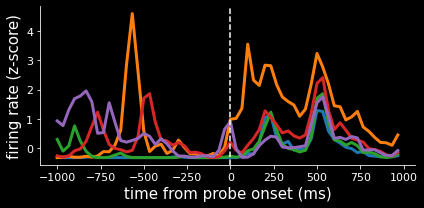

In [282]:
def ctx_raster(id):
    site = id[:7]
    recs = load(site, rasterfs=meta['raster_fs'], recache=False)
    sig = recs['perm0']['resp']

    # calculates response realiability and select only good cells to improve analysis
    r_vals, goodcells = signal_reliability(sig, r'\ASTIM_*', threshold=meta['reliability'])
    goodcells = goodcells.tolist()

    # get the full data raster Context x Probe x Rep x Neuron x Time
    raster = raster_from_sig(sig, probes=expt['probes'], channels=goodcells, contexts=expt['contexts'],
                                              smooth_window=50, raster_fs=meta['raster_fs'],
                                              zscore=meta['zscore'], part='all')
    trialR, _, _ = format_raster(raster)

    return trialR

ctx_raster = ctx_raster(id)

t =  np.linspace(-1, 1, ctx_raster.shape[-1],endpoint=False) * 1000
fig, ax = plt.subplots()

_ = ax.plot(t, ctx_raster[:, goodcells.index(id), :, expt['probes'].index(probe), :].mean(axis=0).T, linewidth=3)
ax.axvline(0, color='white', linestyle='--')

ax.set_xlabel('time from probe onset (ms)')
ax.set_ylabel('firing rate (z-score)')
fig.set_size_inches(6,3)
title = f'example_psth_{id}'
savefig(fig, "DAC4", title)

# Non parametric metric explanation

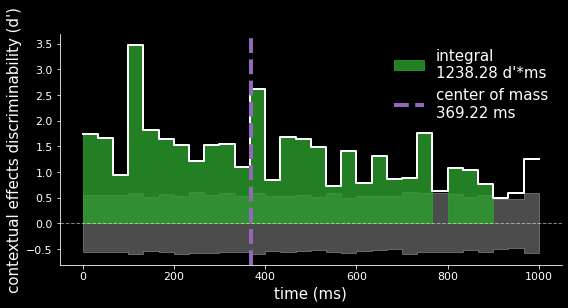

In [283]:
def squarefy(t,y):
    """
    Takes a vector or 2d array meant to be ploted as lines, and transfroms into a format what when plooted, displays
    square time bins, like a histogram or PSTH.
    :param y: vector, or 2d array
    :param t:
    :return:
    """
    # duplicates y values to define left and right edges of square
    # duplicates and rolls t values so  y values are connected by either horizontal or vertical lines
    yy = np.repeat(y,2, axis=0)
    tt = np.roll(np.repeat(t, 2), -1)
    tt[-1] = tt[-2] + t[-1] - t[-2]
    return tt, yy


def non_param_example_plot(id, dprime, confidence_interval, significance, trans_idx_0, trans_idx_1, probe):
    cell_idx = goodcells.index(id) if len(id)>7 else 0
    probe_idx = expt['probes'].index(probe)
    trans_pair_idx = [f'{t0}_{t1}' for t0, t1 in itt.combinations(expt['contexts'], 2)
                      ].index(f'{trans_idx_0}_{trans_idx_1}')

    mean_dprime = dprime[cell_idx, trans_pair_idx, probe_idx, :]
    mean_signif = significance[cell_idx, trans_pair_idx, probe_idx, :]
    CI = confidence_interval[:,cell_idx, trans_pair_idx, probe_idx, :]
    signif_mask = mean_signif>0
    t =  np.linspace(0, 1, mean_dprime.shape[-1],endpoint=False) * 1000

    # calculates center of mass and integral
    significant_abs_mass_center = np.sum(np.abs(mean_dprime[signif_mask]) * t[signif_mask]) / np.sum(np.abs(mean_dprime[signif_mask]))
    significant_abs_sum = np.sum(np.abs(mean_dprime[signif_mask])) * np.mean(np.diff(t))

    fig, axes = plt.subplots()

    # plots dprime plus fit
    tt, mmdd = squarefy(t, mean_dprime)
    axes.plot(tt, mmdd, color='white', linewidth=2)
    _, CCII = squarefy(t, CI.T)
    axes.fill_between(tt, CCII[:,0], CCII[:,1], color='white', alpha=0.3)
    _ = axes.axhline(0, color='white', linewidth=1, linestyle='--', alpha=0.5)

    p1 = axes.fill_between(tt, 0, mmdd, where=np.repeat(signif_mask,2), color='C2', alpha=0.8,
                           label=f"integral\n{significant_abs_sum:.2f} d'*ms")

    p2 = axes.axvline(significant_abs_mass_center, color='C4', linewidth=4, linestyle='--',
                 label=f'center of mass\n{significant_abs_mass_center:.2f} ms')

    axes.legend(handles=[p1, p2], loc='upper right')
    # plt.legend(handles=[p1, p2], bbox_to_anchor=(1.05, 1), loc='upper left')

    # formats axis, legend and so on.
    axes.set_ylabel(f"contextual effects discriminability (d')")
    axes.set_xlabel('time (ms)')

    return fig, axes

ctx0, ctx1 = 0, 1
fig, ax = non_param_example_plot(id, dprime, confidence_interval, significance, ctx0, ctx1, probe)
fig.set_size_inches(8,4)
title =f'metric_calc_example_{id}'
savefig(fig, "DAC4", title)

# multiple comparisons correction

In [221]:
# keywords take from 210302_batch_dprimes_significance.py
multiple_corrections = {'none': (None, None),
                        'time': ([3], None),
                        'full': ([1,2,3], None),
                        'consecutive_2': ([3], 2),
                        'consecutive_3': ([3], 3),
                        'consecutive_4': ([3], 4)}

<ipython-input-283-e599108f95e6>:30: RuntimeWarning: invalid value encountered in double_scalars
  significant_abs_mass_center = np.sum(np.abs(mean_dprime[signif_mask]) * t[signif_mask]) / np.sum(np.abs(mean_dprime[signif_mask]))


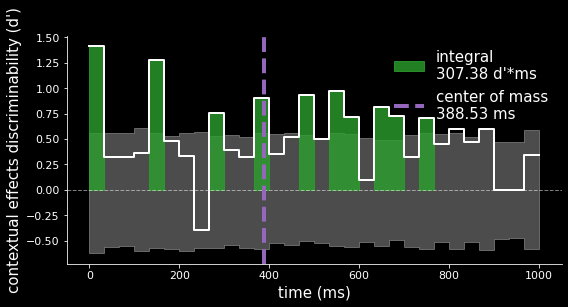

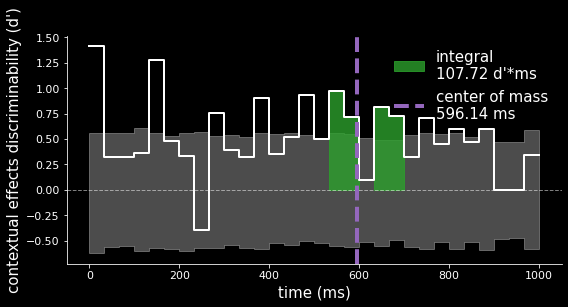

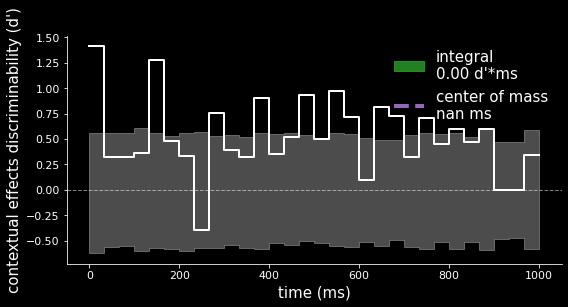

In [284]:
ctx0, ctx1 = 0,3
eg_corrections = {key:val for key, val in multiple_corrections.items()
                  if key in ['time', 'consecutive_2', 'consecutive_3']}
for key, (corr_ax, n_cons) in eg_corrections.items():
    corr_signif, corr_CI = _significance(dprime, shuffled_dprime, corr_ax, n_cons, alpha=alpha)
    fig, ax = non_param_example_plot(id, dprime, corr_CI, corr_signif, ctx0, ctx1, probe)
    fig.set_size_inches(8,4)
    title =f'mult_comp_corr_{id}_{key}_prb{probe}_ctx{ctx0}_{ctx1}'
    savefig(fig, "DAC4", title)


# population example

In [288]:
# selecs sites based on metric values
sorted_SC_pop = filtmerge.sort_values(by=["integral (d'*ms) population", "center of mass (ms) population",
                                  "integral (d'*ms) single cell", "center of mass (ms) single cell"],
                              ascending=[False,False,False,False])

display(sorted_SC_pop.head(10))

metric                                                cellid  \
siteid  probe region context_pair trans_pair                   
ARM031a 1     A1     0_3          silence_diff  ARM031a-54-3   
                                  silence_diff  ARM031a-51-4   
                                  silence_diff  ARM031a-58-3   
                                  silence_diff  ARM031a-24-9   
                                  silence_diff  ARM031a-49-3   
                                  silence_diff  ARM031a-38-3   
                                  silence_diff  ARM031a-31-3   
                                  silence_diff  ARM031a-15-2   
                                  silence_diff  ARM031a-57-2   
                                  silence_diff  ARM031a-34-2   

metric                                          center of mass (ms) single cell  \
siteid  probe region context_pair trans_pair                                      
ARM031a 1     A1     0_3          silence_diff                       210.547712   
                                  silence_diff                       207.789554   
                                  silence_diff                       334.955373   
                                  silence_diff                       138.081148   
                                  silence_diff                       385.178247   
                                  silence_diff                        36.755027   
                                  silence_diff                        25.971336   
                                  silence_diff                       153.055472   
                                  silence_diff                        64.473864   
                                  silence_diff                        33.333333   

metric                                          integral (d'*ms) single cell  \
siteid  probe region context_pair trans_pair                                   
ARM031a 1     A1     0_3          silence_diff                    691.987013   
                                  silence_diff                    543.199967   
                                  silence_diff                    537.845526   
                                  silence_diff                    482.090302   
                                  silence_diff                    193.293061   
                                  silence_diff                    170.715621   
                                  silence_diff                    132.919055   
                                  silence_diff                    131.243372   
                                  silence_diff                    123.039276   
                                  silence_diff                    110.940299   

metric                                          center of mass (ms) population  \
siteid  probe region context_pair trans_pair                                     
ARM031a 1     A1     0_3          silence_diff                      236.099362   
                                  silence_diff                      236.099362   
                                  silence_diff                      236.099362   
                                  silence_diff                      236.099362   
                                  silence_diff                      236.099362   
                                  silence_diff                      236.099362   
                                  silence_diff                      236.099362   
                                  silence_diff                      236.099362   
                                  silence_diff                      236.099362   
                                  silence_diff                      236.099362   

metric                                          integral (d'*ms) population  
siteid  probe region context_pair trans_pair                                 
ARM031a 1     A1     0_3          silence_diff                  1649.187099  
                                  silence_diff        

In [289]:
# get a list of the 2 best and 2 worst cells at this site
site, probe = 'ARM031a', 1 # <- best site
sorted_cells = sorted_SC_pop.loc[(site, str(probe)),'cellid'].values
best_cells = sorted_cells[:2].tolist()
worst_cells = sorted_cells[-2:].tolist()

cells = best_cells + worst_cells

/auto/users/mateo/miniconda3/envs/context_probe_analysis2/lib/python3.8/site-packages/pandas/core/indexing.py:889: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


loading recording from box
You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.
Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  0.003388200529767837
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.


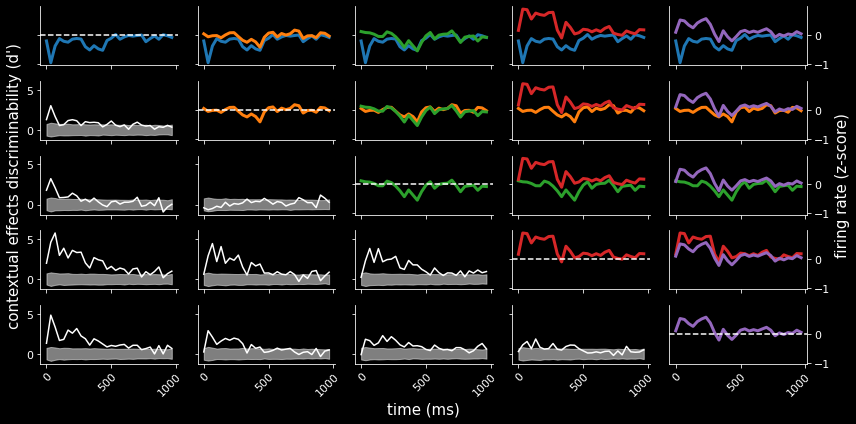

In [293]:
trialR, dprime, shuffled_dprime, significance, confidence_interval, goodcells, t = load_all_raw_data(site)

fig = grid_plot(site, trialR, dprime, confidence_interval, probe)
fig.set_size_inches(12,6)
title =f'context_pair_grid_{site}'
savefig(fig, "DAC4", title)

loading recording from box
loading recording from box
loading recording from box
loading recording from box


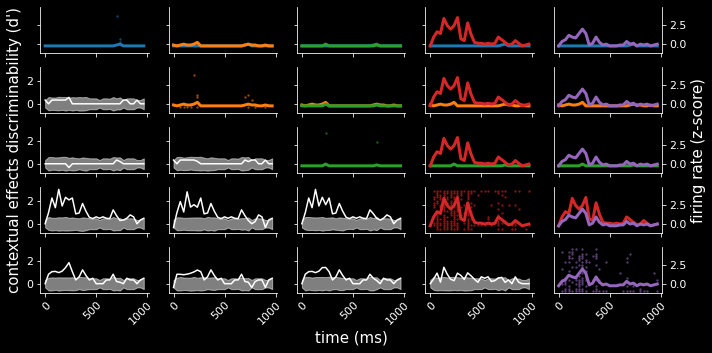

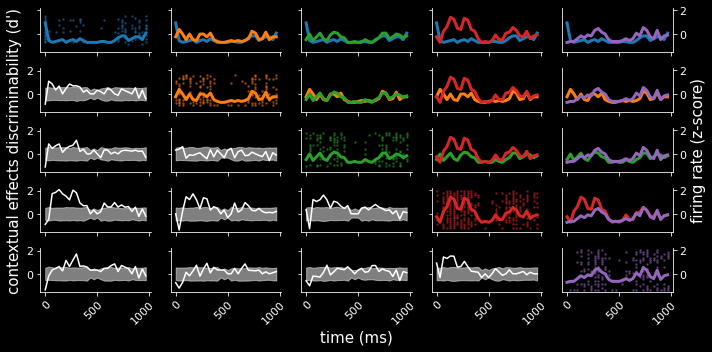

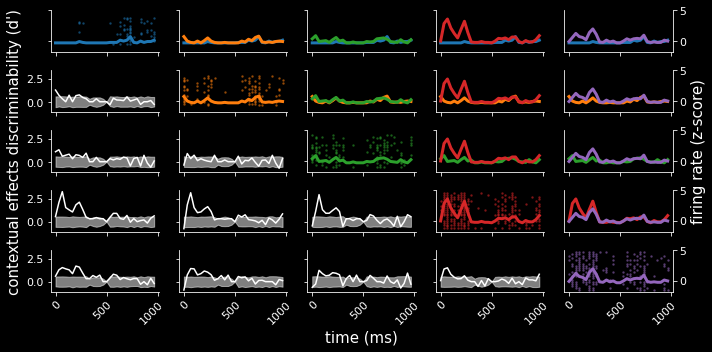

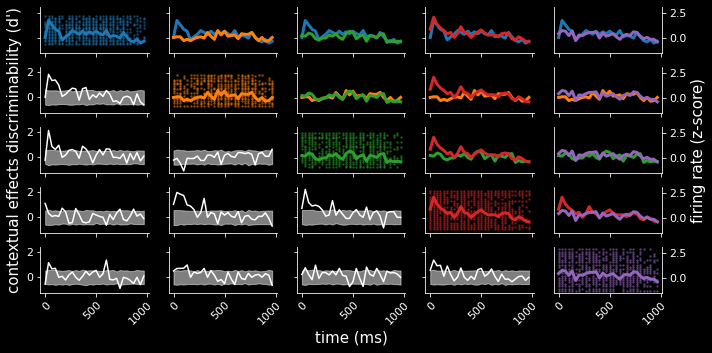

In [295]:
for cell in cells:
    trialR, dprime, shuffled_dprime, significance, confidence_interval, goodcells, t = load_all_raw_data(cell)
    fig = grid_plot(cell, trialR, dprime, confidence_interval, probe)
    fig.set_size_inches(10,5)
    title =f'context_pair_grid_{cell}'
    savefig(fig, "DAC4", title)


# subsampling analysis

In [296]:
def nonan_proportion(arr):
    return np.sum(~np.isnan(arr))/arr.size * 100

def signif_proportion(arr):
    return np.sum(arr>0) / np.size(arr) * 100

In [338]:
# filteres dataframe and adds required columns
filtered = pivoted.loc[pivoted.analysis=='single cell', :]
filtered['site'] = filtered.id.apply(lambda x: x[:7])

ctx_pairs = [pair.split('_') for pair in filtered.context_pair]
ctx_pairs = np.stack(ctx_pairs, axis=0)
filtered['ctx_0'] = ctx_pairs[:, 0]
filtered['ctx_1'] = ctx_pairs[:, 1]

# function to aggregate each single cell. gives the proportion of significant instances
agg_funcs = {"signif_proportion": ("integral (d'*ms)", signif_proportion)}

<ipython-input-338-f43d7c4d2b45>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['site'] = filtered.id.apply(lambda x: x[:7])
<ipython-input-338-f43d7c4d2b45>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['ctx_0'] = ctx_pairs[:, 0]
<ipython-input-338-f43d7c4d2b45>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [322]:
# iterates over all sizes of probe subsampling, i.e. 1, 2, 3 and 4 probes.
all_probes = filtered.probe.sort_values().unique()
prb_subsamp_signif = pd.DataFrame()

for num_probe in range(len(all_probes)):
    num_probe += 1

    n_probe_groups  = list(itt.combinations(all_probes, num_probe))
    # iterates over all possible combinations of n probes
    for pg, probe_group in enumerate(n_probe_groups):
        probes_df = filtered.loc[filtered.probe.isin(probe_group), :].set_index('region', 'site', 'id')
        grouped  = probes_df.groupby(['region', 'site', 'id']).agg(**agg_funcs).copy()
        grouped.loc[grouped['percentage significant(%)'] == 0] = np.nan
        grouped['# different probes'] = num_probe
        grouped['prb_group'] = '_'.join(probe_group)
        prb_subsamp_signif = prb_subsamp_signif.append(grouped.reset_index())

# iterates over all sizes of context subsampling, i.e. 2, 3, 4 and 5 contexts.
all_contexts = np.unique(ctx_pairs)
ctx_subsamp_signif = pd.DataFrame()

for num_ctx in range(2, len(all_contexts)+1):
    n_ctx_groups  = list(itt.combinations(all_contexts, num_ctx))
    # iterates over all possible combinations of n probes
    for cg, ctx_group in enumerate(n_ctx_groups):
        ctx_df = filtered.loc[(filtered.ctx_0.isin(ctx_group)) &
                                 ((filtered.ctx_1.isin(ctx_group))), :].set_index('region', 'site', 'id')
        grouped  = ctx_df.groupby(['region', 'site', 'id']).agg(**agg_funcs).copy()
        grouped.loc[grouped['percentage significant(%)'] == 0] = np.nan
        grouped['# different contexts'] = num_ctx
        grouped['ctx_group'] = '_'.join(ctx_group)
        ctx_subsamp_signif = ctx_subsamp_signif.append(grouped.reset_index())


## Proportion of significant instances per cells
only looking at cells with at least one significant instance

## Proportion of significant instances for individual cells
only looking at cells with at least one significant instance

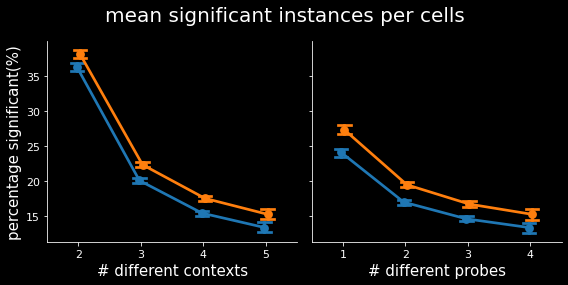

In [335]:
fig, (ctx_ax, prb_ax) = plt.subplots(1, 2, sharey=True, figsize=[10,5])
_ = sns.pointplot(x='n_contexts', y='signif_proportion', data=ctx_subsamp_signif, hue='region', dodge=True, ax=ctx_ax)
_ = sns.pointplot(x='n_probes', y='signif_proportion', data=prb_subsamp_signif, hue='region', dodge=True, ax=prb_ax)

fig.suptitle('Proportion of significant instances\nfor individual cells', fontsize=20)

## count of significant cells by site and or region

In [337]:
# collapses across neurons. Keeps information about region and ctx / prb subsamples.

ctx_count_by_site = ctx_subsamp_signif.set_index(['region','site', 'n_contexts','ctx_group']
                                     ).groupby(['region', 'site', 'n_contexts','ctx_group']
                                     ).agg(signfi_cell_prop=('signif_proportion', nonan_proportion)).reset_index()

prb_count_by_site = prb_subsamp_signif.set_index(['region','site', 'n_probes','prb_group']
                                     ).groupby(['region', 'site', 'n_probes','prb_group']
                                     ).agg(signfi_cell_prop=('signif_proportion', nonan_proportion)).reset_index()


KeyError: "None of ['n_contexts'] are in the columns"

In [ ]:
# collapses across neurons, grouping by site. Keeps information about region and ctx / prb subsamples.

# ctx_count_by_site = ctx_subsamp_signif.set_index(['region','site', 'n_contexts','ctx_group']
#                                      ).groupby(['region', 'site', 'n_contexts','ctx_group']
#                                      ).agg(signfi_cell_prop=('signif_proportion', nonan_proportion)
#                                      ).groupby(['region', 'site', 'n_contexts']
#                                      ).agg(signfi_cell_prop=('signfi_cell_prop', np.nanmean)).reset_index()
#
# prb_count_by_site = prb_subsamp_signif.set_index(['region','site', 'n_probes','prb_group']
#                                      ).groupby(['region', 'site', 'n_probes','prb_group']
#                                      ).agg(signfi_cell_prop=('signif_proportion', nonan_proportion)
#                                      ).groupby(['region', 'site', 'n_probes']
#                                      ).agg(signfi_cell_prop=('signfi_cell_prop', np.nanmean)).reset_index()

In [ ]:
fig, (ctx_ax, prb_ax) = plt.subplots(1, 2, sharey=True, figsize=[10,5])
_ = sns.pointplot(x='n_contexts', y='signfi_cell_prop', hue='region', data=ctx_count_by_site,
                  dodge=True, s=2, capsize=0.2, ci=68, ax=ctx_ax,)
_ = sns.stripplot(x='n_contexts', y='signfi_cell_prop', hue='region', data=ctx_count_by_site,
                  dodge=True, alpha=0.1, ax=ctx_ax)
ctx_ax.legend([],[], frameon=False)

_ = sns.pointplot(x='n_probes', y='signfi_cell_prop', hue='region', data=prb_count_by_site,
                  dodge=True, s=2, capsize=0.2, ci=68, ax=prb_ax)
_ = sns.stripplot(x='n_probes', y='signfi_cell_prop', hue='region', data=prb_count_by_site,
                  dodge=True, alpha=0.1, ax=prb_ax)
prb_ax.legend([],[], frameon=False)

fig.suptitle('count of significant cells\npers site', fontsize=20)